In [ ]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm import tqdm

from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

# -------- CONFIG --------
CALENDAR_PATH = "calander_cleaned_no_garbage.csv"  
LISTINGS_PATH = "listings_cleaned_no_garbage.csv"   

DATE_COL = "date"
AVAIL_COL = "available"
PRICE_COL = "price"
ADJ_PRICE_COL = "adjusted_price"        

USE_ADJUSTED_PRICE = True              
CITY_LEVEL_ONLY = False                 
BOROUGH = "Manhattan"                   

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:
# %%
cal_path = Path(CALENDAR_PATH)
assert cal_path.exists(), f"Calendar file not found: {cal_path.resolve()}"

calendar = pd.read_csv(
    cal_path,
    parse_dates=[DATE_COL],
    dtype={AVAIL_COL: str}
)

print("Calendar head:")
print(calendar.head())
print("\nCalendar info:")
print(calendar.info())


Calendar head:
   listing_id       date available    price adjusted_price  minimum_nights  \
0        2595 2023-03-07         t  $150.00        $150.00            30.0   
1        2595 2023-03-08         t  $150.00        $150.00            30.0   
2        2595 2023-03-09         t  $150.00        $150.00            30.0   
3        2595 2023-03-10         f  $150.00        $150.00            30.0   
4        2595 2023-03-11         f  $150.00        $150.00            30.0   

   maximum_nights  
0          1125.0  
1          1125.0  
2          1125.0  
3          1125.0  
4          1125.0  

Calendar info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15664741 entries, 0 to 15664740
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_n

In [3]:
# %%
# Optional: listings for neighbourhood_group
listings = None
list_path = Path(LISTINGS_PATH)
if list_path.exists():
    listings = pd.read_csv(list_path)
    print("\nListings head:")
    print(listings.head())
else:
    print("\nListings file not found – proceeding without neighbourhood info.")



Listings head:
     id                                         name neighbourhood_group  \
0  2595                        Skylit Midtown Castle           Manhattan   
1  5121                              BlissArtsSpace!            Brooklyn   
2  5203           Cozy Clean Guest Room - Family Apt           Manhattan   
3  5178              Large Furnished Room Near B'way           Manhattan   
4  5136  Large Sunny Brooklyn Duplex, Patio + Garden            Brooklyn   

        neighbourhood        room_type  price  minimum_nights  \
0             Midtown  Entire home/apt    150              30   
1  Bedford-Stuyvesant     Private room     60              30   
2     Upper West Side     Private room     75               2   
3             Midtown     Private room     68               2   
4         Sunset Park  Entire home/apt    275              60   

   number_of_reviews  availability_365  
0                 49               314  
1                 50               365  
2            

In [4]:
# %%
cal = calendar.copy()

# Normalize availability flags
cal[AVAIL_COL] = cal[AVAIL_COL].astype(str).str.strip().str.lower()
cal["is_available"] = cal[AVAIL_COL].map({"t": 1, "true": 1, "f": 0, "false": 0})
cal["is_available"] = cal["is_available"].fillna(1).astype(int)
cal["is_booked"] = 1 - cal["is_available"]

# Price cleaning
def clean_price(series):
    return (
        series.astype(str)
        .str.replace(r"[\$,]", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )

cal[PRICE_COL] = clean_price(cal[PRICE_COL])

if ADJ_PRICE_COL in cal.columns:
    cal[ADJ_PRICE_COL] = clean_price(cal[ADJ_PRICE_COL])

# Choose price
if USE_ADJUSTED_PRICE and ADJ_PRICE_COL in cal.columns:
    cal["daily_price"] = cal[ADJ_PRICE_COL]
else:
    cal["daily_price"] = cal[PRICE_COL]

# Remove insane prices (e.g. > $2000)
cal = cal[(cal["daily_price"].isna()) | (cal["daily_price"] <= 2000)]

print("\nAfter cleaning:")
print(cal[[DATE_COL, "is_available", "is_booked", "daily_price"]].head())



After cleaning:
        date  is_available  is_booked  daily_price
0 2023-03-07             1          0        150.0
1 2023-03-08             1          0        150.0
2 2023-03-09             1          0        150.0
3 2023-03-10             0          1        150.0
4 2023-03-11             0          1        150.0


In [5]:
# %%
if listings is not None:
    # Expect: calendar has 'listing_id', listings has 'id'
    if "listing_id" in cal.columns and "id" in listings.columns:
        cal = cal.merge(
            listings[["id", "neighbourhood_group", "neighbourhood"]],
            left_on="listing_id",
            right_on="id",
            how="left"
        )
        print("\nMerged calendar with listings. Sample:")
        print(cal[["listing_id", "neighbourhood_group", "neighbourhood"]].head())
    else:
        print("\nCould not merge – expected 'listing_id' in calendar and 'id' in listings.")
else:
    print("\nSkipping neighbourhood merge.")



Merged calendar with listings. Sample:
   listing_id neighbourhood_group neighbourhood
0        2595           Manhattan       Midtown
1        2595           Manhattan       Midtown
2        2595           Manhattan       Midtown
3        2595           Manhattan       Midtown
4        2595           Manhattan       Midtown


In [6]:
# %%
cal = calendar.copy()

# Normalize availability flags
cal[AVAIL_COL] = cal[AVAIL_COL].astype(str).str.strip().str.lower()
cal["is_available"] = cal[AVAIL_COL].map({"t": 1, "true": 1, "f": 0, "false": 0})
cal["is_available"] = cal["is_available"].fillna(1).astype(int)
cal["is_booked"] = 1 - cal["is_available"]

# Price cleaning
def clean_price(series):
    return (
        series.astype(str)
        .str.replace(r"[\$,]", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )

cal[PRICE_COL] = clean_price(cal[PRICE_COL])

if ADJ_PRICE_COL in cal.columns:
    cal[ADJ_PRICE_COL] = clean_price(cal[ADJ_PRICE_COL])

# Choose price
if USE_ADJUSTED_PRICE and ADJ_PRICE_COL in cal.columns:
    cal["daily_price"] = cal[ADJ_PRICE_COL]
else:
    cal["daily_price"] = cal[PRICE_COL]

# Remove insane prices (e.g. > $2000)
cal = cal[(cal["daily_price"].isna()) | (cal["daily_price"] <= 2000)]

print("\nAfter cleaning:")
print(cal[[DATE_COL, "is_available", "is_booked", "daily_price"]].head())



After cleaning:
        date  is_available  is_booked  daily_price
0 2023-03-07             1          0        150.0
1 2023-03-08             1          0        150.0
2 2023-03-09             1          0        150.0
3 2023-03-10             0          1        150.0
4 2023-03-11             0          1        150.0


In [7]:
# %%
if listings is not None:
    # Expect: calendar has 'listing_id', listings has 'id'
    if "listing_id" in cal.columns and "id" in listings.columns:
        cal = cal.merge(
            listings[["id", "neighbourhood_group", "neighbourhood"]],
            left_on="listing_id",
            right_on="id",
            how="left"
        )
        print("\nMerged calendar with listings. Sample:")
        print(cal[["listing_id", "neighbourhood_group", "neighbourhood"]].head())
    else:
        print("\nCould not merge – expected 'listing_id' in calendar and 'id' in listings.")
else:
    print("\nSkipping neighbourhood merge.")



Merged calendar with listings. Sample:
   listing_id neighbourhood_group neighbourhood
0        2595           Manhattan       Midtown
1        2595           Manhattan       Midtown
2        2595           Manhattan       Midtown
3        2595           Manhattan       Midtown
4        2595           Manhattan       Midtown


In [8]:
# %%
if CITY_LEVEL_ONLY or "neighbourhood_group" not in cal.columns:
    print("\nUsing city-level analysis (all NYC listings).")
    cal_used = cal.copy()
else:
    cal_used = cal[cal["neighbourhood_group"] == BOROUGH].copy()
    print(f"\nUsing only borough = {BOROUGH}")
    print(f"Rows for {BOROUGH}: {len(cal_used)}")

# Just in case:
cal_used = cal_used.sort_values(DATE_COL)



Using only borough = Manhattan
Rows for Manhattan: 6369899


In [9]:
# %%
daily = (
    cal_used
    .groupby(DATE_COL)
    .agg(
        total_listings=("listing_id", "nunique"),
        total_booked=("is_booked", "sum"),
        avg_price=("daily_price", "mean"),
    )
    .reset_index()
)

daily["occupancy_rate"] = daily["total_booked"] / daily["total_listings"]

daily = daily.set_index(DATE_COL).sort_index()

print("\nDaily sample:")
print(daily.head())
print("\nDate range:", daily.index.min(), "→", daily.index.max())



Daily sample:
            total_listings  total_booked   avg_price  occupancy_rate
date                                                                
2023-03-06           10145          8011  218.392192        0.789650
2023-03-07           17497         13689  230.947928        0.782363
2023-03-08           17499         13211  231.708293        0.754957
2023-03-09           17498         13050  232.971765        0.745800
2023-03-10           17488         13301  242.892771        0.760579

Date range: 2023-03-06 00:00:00 → 2024-03-05 00:00:00


In [10]:
# %%
weekly = pd.DataFrame()
weekly["occupancy_rate"] = daily["occupancy_rate"].resample("W-MON").mean()
weekly["avg_price"] = daily["avg_price"].resample("W-MON").mean()
weekly["total_booked"] = daily["total_booked"].resample("W-MON").sum()
weekly["total_listings"] = daily["total_listings"].resample("W-MON").mean()

weekly = weekly.dropna(subset=["occupancy_rate"])
print("Weekly shape:", weekly.shape)
print(weekly.head())
print(weekly.tail())


Weekly shape: (54, 4)
            occupancy_rate   avg_price  total_booked  total_listings
date                                                                
2023-03-06        0.789650  218.392192          8011    10145.000000
2023-03-13        0.754033  235.857255         92347    17496.000000
2023-03-20        0.732148  241.554045         89568    17477.000000
2023-03-27        0.692222  241.115095         84746    17489.571429
2023-04-03        0.689157  246.753279         84311    17477.142857
            occupancy_rate   avg_price  total_booked  total_listings
date                                                                
2024-02-12        0.634668  255.222191         77656    17479.571429
2024-02-19        0.636167  256.369547         77772    17464.428571
2024-02-26        0.636107  256.336307         77794    17471.000000
2024-03-04        0.649725  256.694265         79375    17452.571429
2024-03-11        0.804401  266.155823          5885     7316.000000


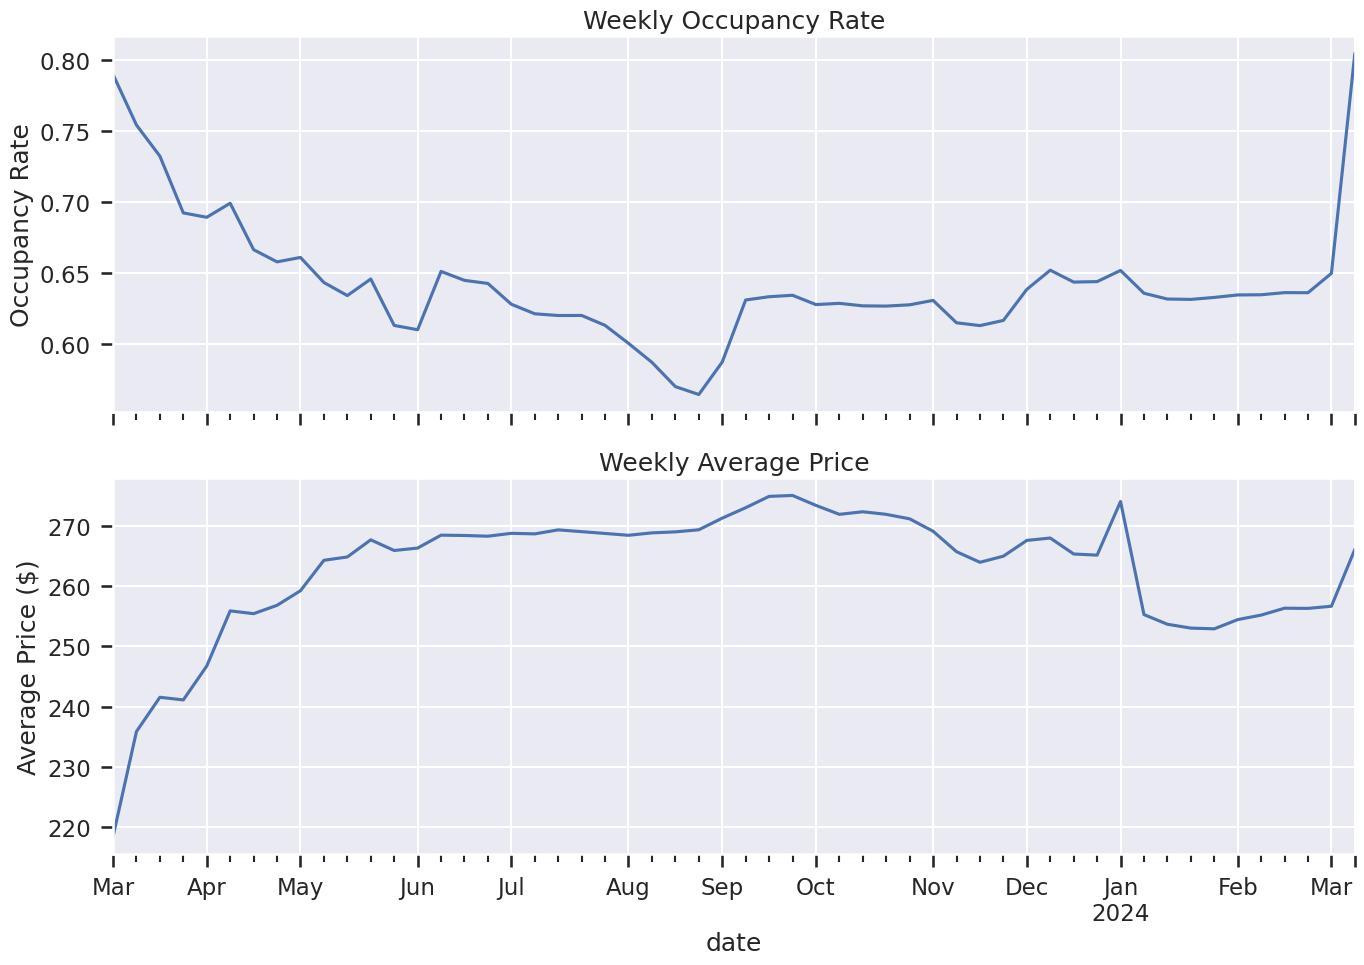

In [11]:
# %%
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

weekly["occupancy_rate"].plot(ax=ax[0])
ax[0].set_title("Weekly Occupancy Rate")
ax[0].set_ylabel("Occupancy Rate")

weekly["avg_price"].plot(ax=ax[1])
ax[1].set_title("Weekly Average Price")
ax[1].set_ylabel("Average Price ($)")

plt.tight_layout()
plt.show()


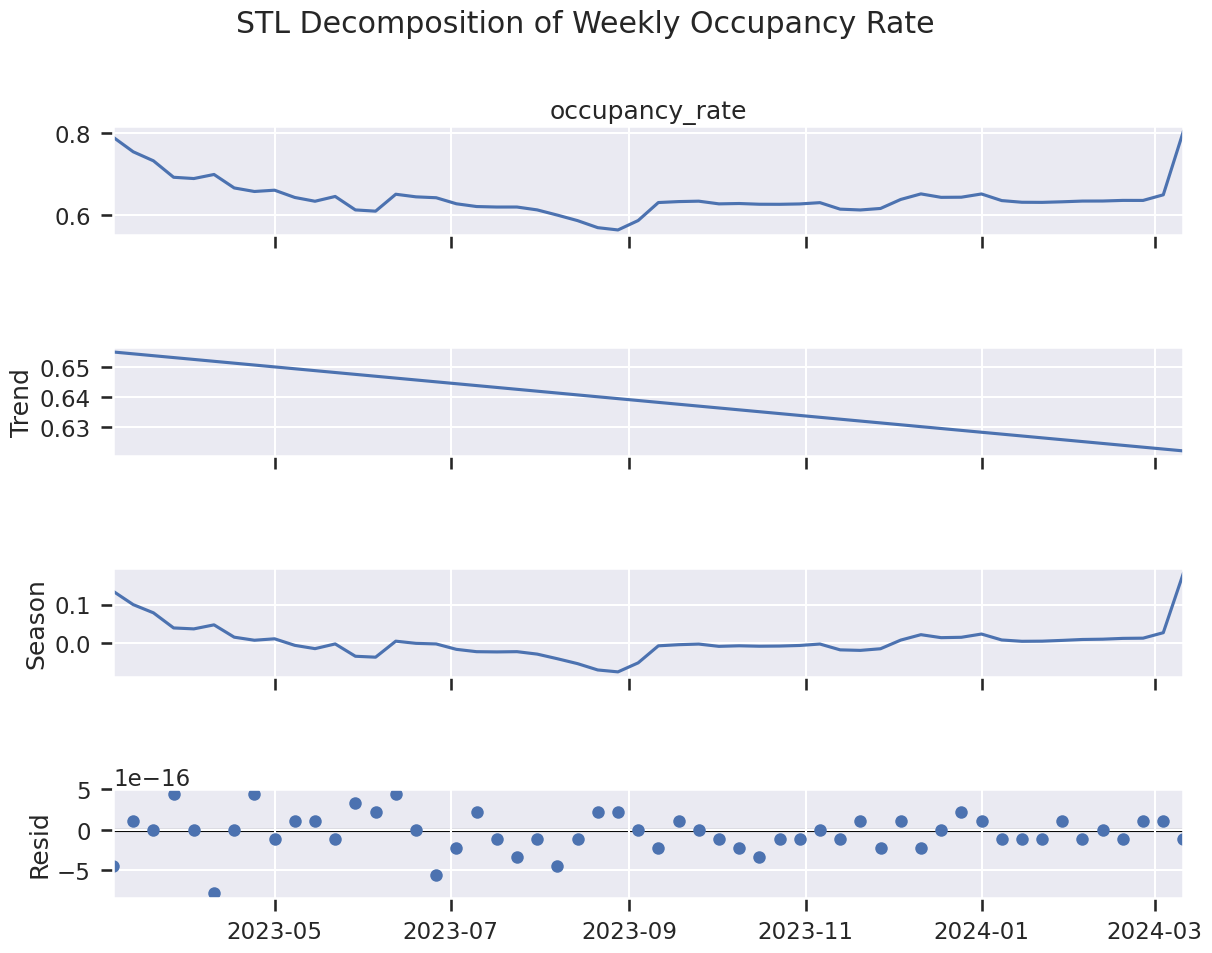

In [12]:
# %%
series_w = weekly["occupancy_rate"].asfreq("W-MON")

stl = STL(series_w, period=52, robust=True)  # 52 weeks per year
res = stl.fit()

fig = res.plot()
fig.set_size_inches(14, 10)
plt.suptitle("STL Decomposition of Weekly Occupancy Rate", y=1.02)
plt.show()


In [13]:
# %%
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    nonzero = y_true != 0
    return (np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero]).mean()) * 100


In [14]:
# %%
series_w = weekly["occupancy_rate"].asfreq("W-MON").dropna()
print("Weekly series length:", len(series_w))
print("From:", series_w.index.min(), "to:", series_w.index.max())

# Train-test split: last 8 weeks as test
horizon = 8
train_w = series_w.iloc[:-horizon]
test_w = series_w.iloc[-horizon:]

print("\nTrain period:", train_w.index.min(), "→", train_w.index.max())
print("Test period :", test_w.index.min(), "→", test_w.index.max())


Weekly series length: 54
From: 2023-03-06 00:00:00 to: 2024-03-11 00:00:00

Train period: 2023-03-06 00:00:00 → 2024-01-15 00:00:00
Test period : 2024-01-22 00:00:00 → 2024-03-11 00:00:00


In [16]:
# %%
# auto_arima to find best (p,d,q)(P,D,Q,52)
stepwise_model = auto_arima(
    train_w,
    seasonal=False,
    m=1,              # weekly data, yearly seasonality
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print("\nBest ARIMA model found:")
print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-236.197, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-238.013, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-238.013, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-238.896, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-238.006, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-238.657, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-238.260, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-236.680, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-239.566, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-239.084, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-238.663, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-238.586, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-237.055, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.972 seconds

Best ARIMA model foun

In [17]:
# %%
n_test = len(test_w)
arima_forecast = stepwise_model.predict(n_periods=n_test)
arima_forecast = pd.Series(arima_forecast, index=test_w.index, name="forecast")

print("\nARIMA forecast vs actual (test):")
print(pd.DataFrame({"actual": test_w, "forecast": arima_forecast}))

print(f"\nauto_ARIMA Test RMSE: {rmse(test_w, arima_forecast):.4f}")
print(f"auto_ARIMA Test MAPE: {mape(test_w, arima_forecast):.2f}%")



ARIMA forecast vs actual (test):
              actual  forecast
date                          
2024-01-22  0.631405  0.632653
2024-01-29  0.632792  0.632653
2024-02-05  0.634532  0.632653
2024-02-12  0.634668  0.632653
2024-02-19  0.636167  0.632653
2024-02-26  0.636107  0.632653
2024-03-04  0.649725  0.632653
2024-03-11  0.804401  0.632653

auto_ARIMA Test RMSE: 0.0611
auto_ARIMA Test MAPE: 3.24%


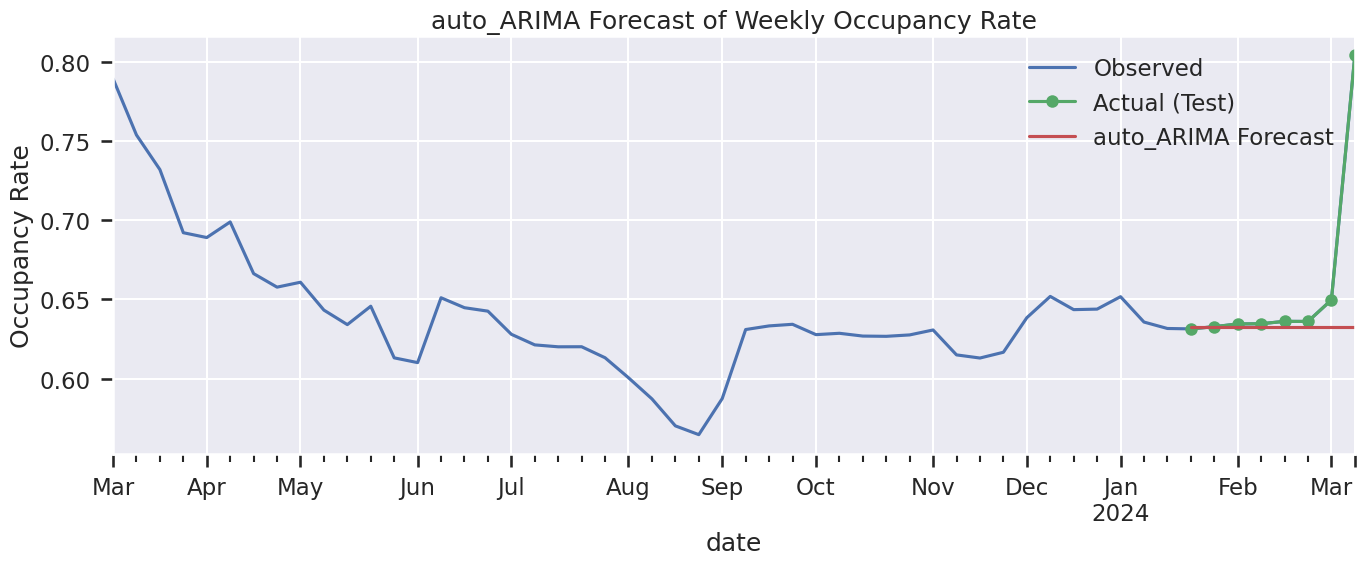

In [19]:
# %%
fig, ax = plt.subplots(figsize=(14, 6))
series_w.plot(ax=ax, label="Observed")
test_w.plot(ax=ax, label="Actual (Test)", marker="o")
arima_forecast.plot(ax=ax, label="auto_ARIMA Forecast", marker="x")

ax.set_title("auto_ARIMA Forecast of Weekly Occupancy Rate")
ax.set_ylabel("Occupancy Rate")
ax.legend()
plt.tight_layout()
plt.show()


In [20]:
# %%
from prophet import Prophet

# Scale occupancy to [0,1] – usually already in that range, but we normalize to be safe
min_occ = series_w.min()
max_occ = series_w.max()
series_norm = (series_w - min_occ) / (max_occ - min_occ + 1e-8)

# Prepare Prophet dataframe
df_prophet = series_norm.reset_index()
df_prophet.columns = ["ds", "y"]

# Same horizon as ARIMA
train_p = df_prophet.iloc[:-horizon]
test_p = df_prophet.iloc[-horizon:]


Importing plotly failed. Interactive plots will not work.


In [21]:
# %%
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)
m.fit(train_p)

future = m.make_future_dataframe(periods=horizon, freq="W-MON")
forecast = m.predict(future)

# Align predictions with test period
forecast_idx = forecast.set_index("ds")
prophet_pred_norm = forecast_idx.loc[test_p["ds"], "yhat"]

# Unscale back to original occupancy range
prophet_pred = prophet_pred_norm * (max_occ - min_occ + 1e-8) + min_occ
prophet_pred = pd.Series(prophet_pred.values, index=test_w.index, name="prophet_forecast")

# Clip to [0,1] to avoid nonsense values
prophet_pred = prophet_pred.clip(0, 1)

print("\nProphet forecast vs actual (test):")
print(pd.DataFrame({"actual": test_w, "prophet": prophet_pred}))

print(f"\nProphet Test RMSE: {rmse(test_w, prophet_pred):.4f}")
print(f"Prophet Test MAPE: {mape(test_w, prophet_pred):.2f}%")


15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing



Prophet forecast vs actual (test):
              actual   prophet
date                          
2024-01-22  0.631405  0.620218
2024-01-29  0.632792  0.635476
2024-02-05  0.634532  0.702012
2024-02-12  0.634668  0.819768
2024-02-19  0.636167  0.952457
2024-02-26  0.636107  1.000000
2024-03-04  0.649725  1.000000
2024-03-11  0.804401  1.000000

Prophet Test RMSE: 0.2325
Prophet Test MAPE: 28.39%


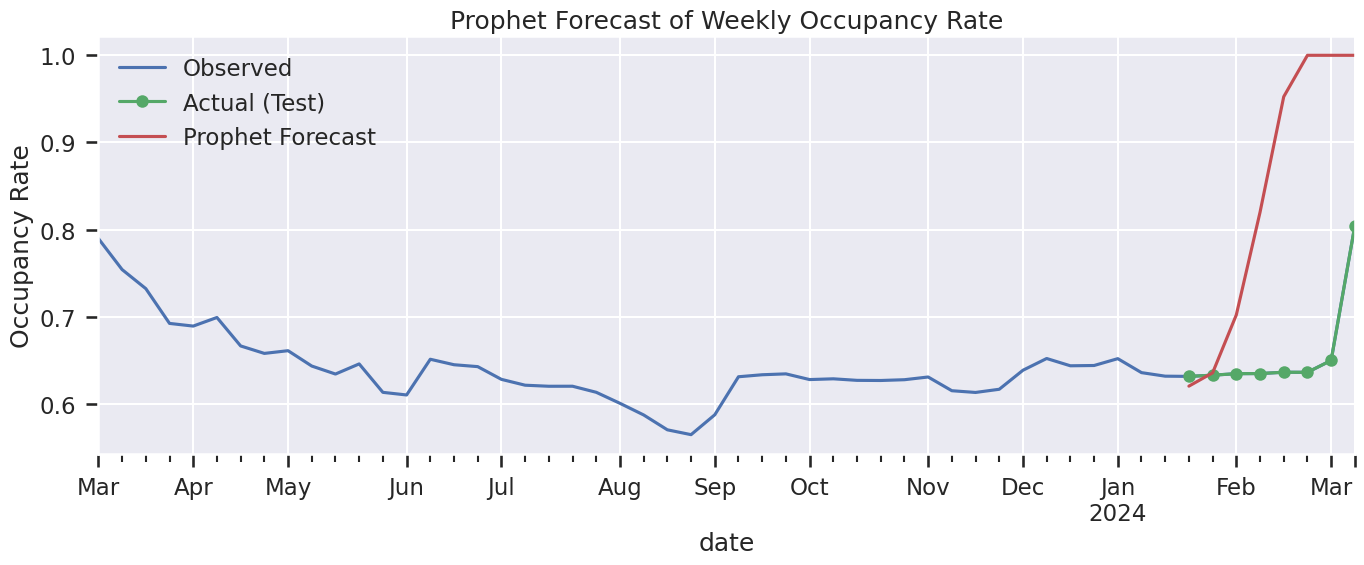

In [22]:
# %%
fig, ax = plt.subplots(figsize=(14, 6))
series_w.plot(ax=ax, label="Observed")
test_w.plot(ax=ax, label="Actual (Test)", marker="o")
prophet_pred.plot(ax=ax, label="Prophet Forecast", marker="x")

ax.set_title("Prophet Forecast of Weekly Occupancy Rate")
ax.set_ylabel("Occupancy Rate")
ax.legend()
plt.tight_layout()
plt.show()


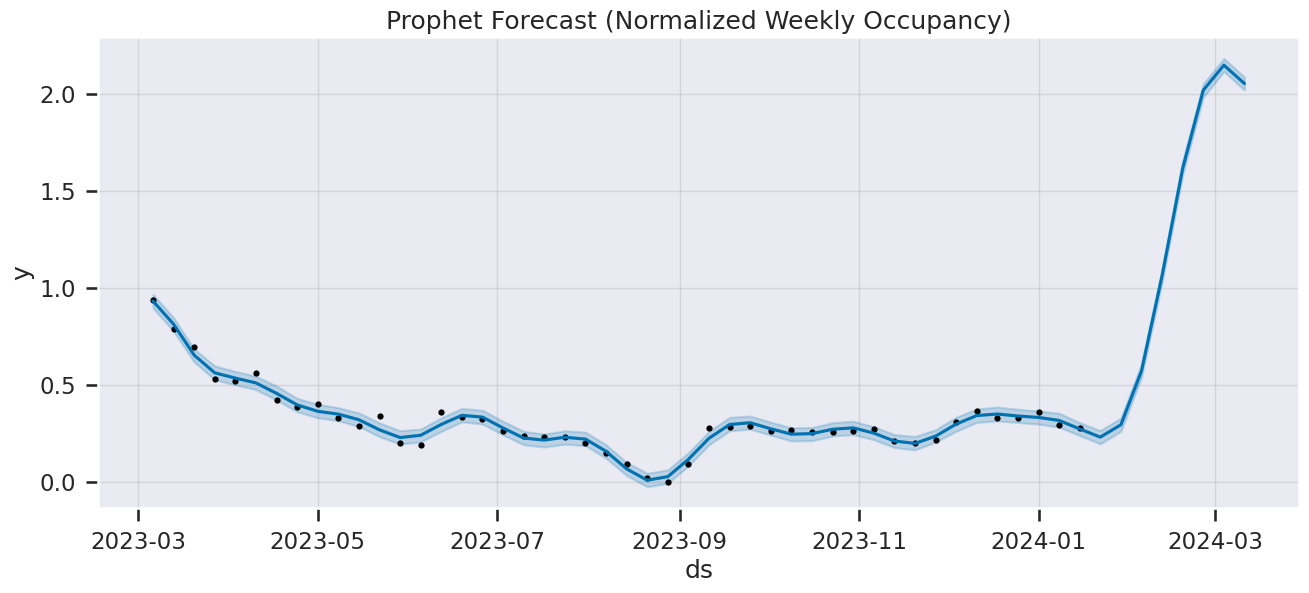

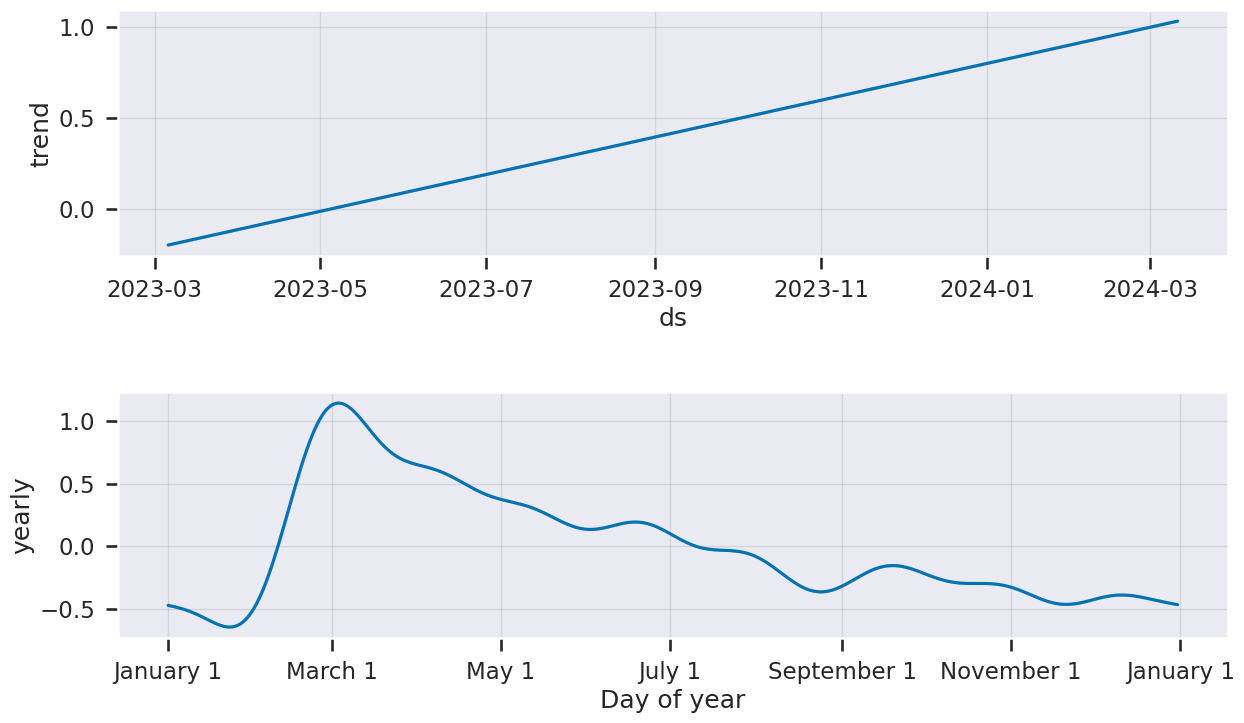

In [23]:
# %%
fig1 = m.plot(forecast)
fig1.set_size_inches(14, 6)
plt.title("Prophet Forecast (Normalized Weekly Occupancy)")
plt.show()

fig2 = m.plot_components(forecast)
fig2.set_size_inches(14, 8)
plt.show()


In [24]:
# %%
# In-sample prediction for full series
full_pred = stepwise_model.predict_in_sample()
full_pred = pd.Series(full_pred, index=train_w.index, name="in_sample_pred")

# To include test as well, you can extend if needed; for spike detection,
# using train period is often enough.
residuals = train_w - full_pred

z_scores = (residuals - residuals.mean()) / (residuals.std() + 1e-8)
threshold = 2.0  # |z| > 2 considered spike
spikes = z_scores[np.abs(z_scores) > threshold]

print("Detected demand spikes (|z| > 2):")
print(spikes)


Detected demand spikes (|z| > 2):
date
2023-03-06    6.57324
Freq: W-MON, dtype: float64


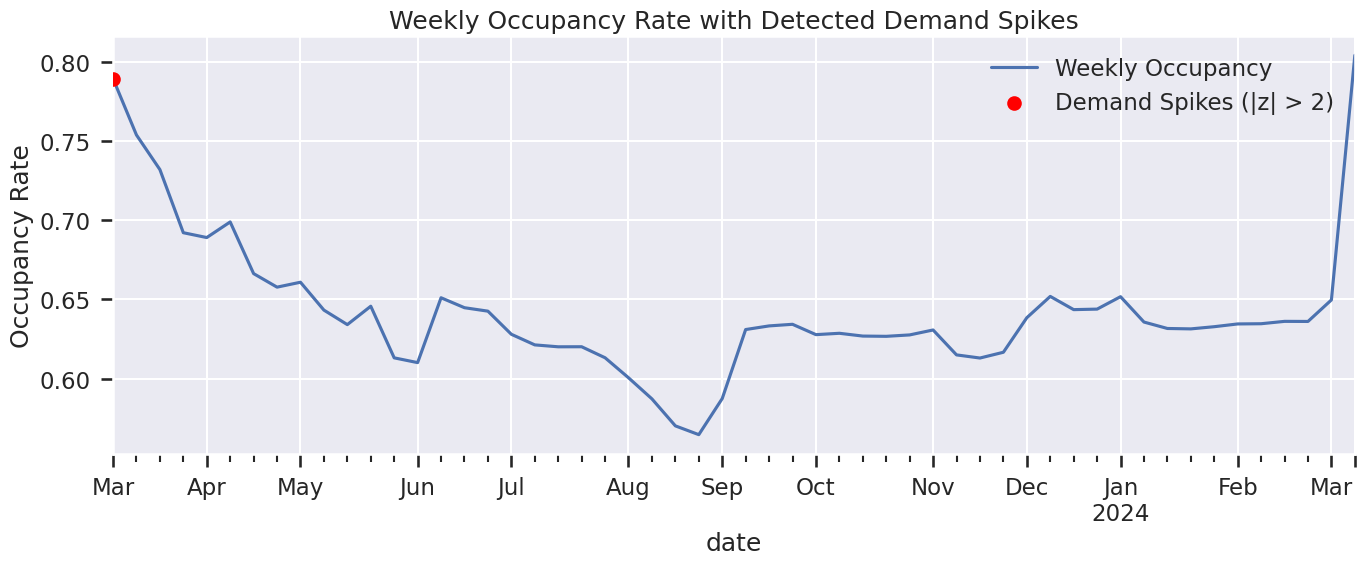

In [25]:
# %%
fig, ax = plt.subplots(figsize=(14, 6))
series_w.plot(ax=ax, label="Weekly Occupancy")

ax.scatter(
    spikes.index,
    series_w.loc[spikes.index],
    color="red",
    label="Demand Spikes (|z| > 2)",
    zorder=5
)

ax.set_title("Weekly Occupancy Rate with Detected Demand Spikes")
ax.set_ylabel("Occupancy Rate")
ax.legend()
plt.tight_layout()
plt.show()
